# H5T0_MLP: implement an MLP using PyTorch for image classification

### create your "signature":
#### Run the cell but do NOT modify the cell
#### The signature needs to be displayed right below the cell in this file

In [1]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature_for_mlp=[socket.gethostbyname(socket.gethostname()),
                   getpass.getuser(),
                   datetime.now(),
                   random.random()]
print(signature_for_mlp) 

['10.5.0.2', 'ARamo', datetime.datetime(2025, 12, 10, 23, 57, 41, 802357), 0.6464532747921866]


In [2]:
#sample code to save model and signature
#torch.save({"model":model.state_dict(),
#            "signature":signature_for_mlp},
#            "MLP_best.pt") 

### This is a complete application of image classification using an MLP
steps: \
define an MLP \
define a function for training the MLP \
define a function for testing the MLP \
define a function for saving the model and your `signature_for_mlp` \
load data \
train the MLP in a for loop using the training set and the validation set\
evalaute the best model on the test set\
display accuracy and confusion matrix for each of the three sets: train, validation, and test sets
### you may use the code in lecture nodes
### write your code below this line

In [3]:
# 1) Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [4]:
# 2) Load data and reshape
data = torch.load("H5T0_train_val_test_data.pt", weights_only=False)
X_train = data["X_train"]
Y_train = data["Y_train"]
X_val = data["X_val"]
Y_val = data["Y_val"]
X_test = data["X_test"]
Y_test = data["Y_test"]

# Flatten images
X_train = X_train.reshape(-1, 28*28)
X_val = X_val.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).long()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).long()

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: torch.Size([1000, 784]), Val: torch.Size([1000, 784]), Test: torch.Size([1000, 784])


In [5]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden1=512, hidden2=256, num_classes=10, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(inplace=True),
            nn.Dropout(p_dropout),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(inplace=True),
            nn.Dropout(p_dropout),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    avg_loss = running_loss / len(loader)
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc

def eval_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc, np.array(all_preds), np.array(all_labels)

In [7]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
test_ds = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

num_epochs = 50
best_val_acc = 0.0
best_state = None
patience = 7
epochs_without_improve = 0

print("Starting MLP training...")
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, _, _ = eval_model(model, val_loader, device)
    scheduler.step()
    
    improved = val_acc > best_val_acc
    if improved:
        best_val_acc = val_acc
        best_state = model.state_dict().copy()
        epochs_without_improve = 0
        status = "(best)"
    else:
        epochs_without_improve += 1
        status = ""
    
    print(f"Epoch {epoch:02d}/{num_epochs} | loss={train_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f} {status}")
    
    if epochs_without_improve >= patience:
        print(f"Early stopping triggered after {epoch} epochs.")
        break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
print(f"\nBest validation accuracy: {best_val_acc:.4f}")

Starting MLP training...
Epoch 01/50 | loss=1.2201 | train_acc=0.5740 | val_acc=0.6240 (best)
Epoch 02/50 | loss=0.7161 | train_acc=0.7320 | val_acc=0.6770 (best)
Epoch 03/50 | loss=0.6167 | train_acc=0.7780 | val_acc=0.7730 (best)
Epoch 04/50 | loss=0.5786 | train_acc=0.7850 | val_acc=0.7170 
Epoch 05/50 | loss=0.4342 | train_acc=0.8380 | val_acc=0.7490 
Epoch 06/50 | loss=0.4358 | train_acc=0.8450 | val_acc=0.7780 (best)
Epoch 07/50 | loss=0.3761 | train_acc=0.8570 | val_acc=0.7680 
Epoch 08/50 | loss=0.3725 | train_acc=0.8680 | val_acc=0.7540 
Epoch 09/50 | loss=0.3455 | train_acc=0.8780 | val_acc=0.7540 
Epoch 10/50 | loss=0.2866 | train_acc=0.8910 | val_acc=0.7670 
Epoch 11/50 | loss=0.2296 | train_acc=0.9190 | val_acc=0.8060 (best)
Epoch 12/50 | loss=0.1849 | train_acc=0.9370 | val_acc=0.7920 
Epoch 13/50 | loss=0.1687 | train_acc=0.9380 | val_acc=0.7990 
Epoch 14/50 | loss=0.1346 | train_acc=0.9570 | val_acc=0.8040 
Epoch 15/50 | loss=0.1462 | train_acc=0.9500 | val_acc=0.8180 (


Final Results:
Training Accuracy:   1.0000
Validation Accuracy: 0.8170
Test Accuracy:       0.7950


C:\Users\ARamo\AppData\Local\Temp\ipykernel_27908\442658338.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


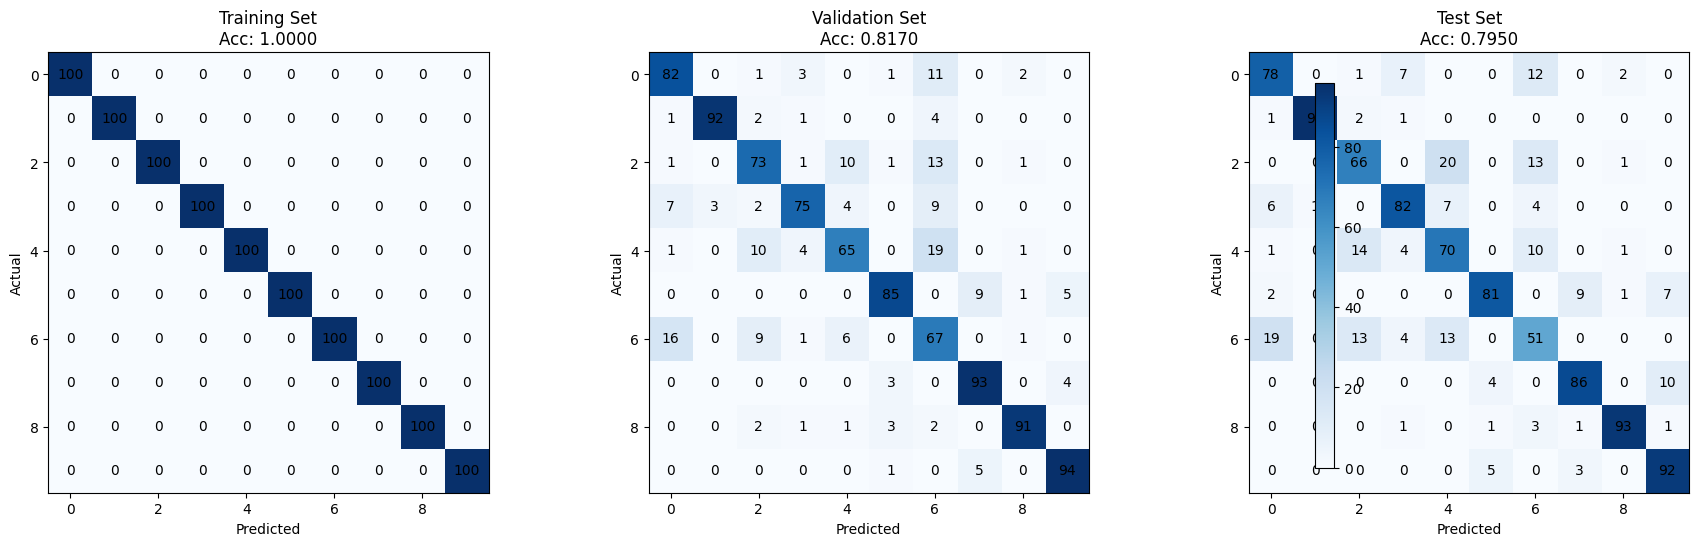

In [8]:
train_acc, train_preds, train_labels = eval_model(model, train_loader, device)
val_acc, val_preds, val_labels = eval_model(model, val_loader, device)
test_acc, test_preds, test_labels = eval_model(model, test_loader, device)

print("\nFinal Results:")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)
test_cm = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, cm, title, acc in [
    (axes[0], train_cm, 'Training Set', train_acc),
    (axes[1], val_cm, 'Validation Set', val_acc),
    (axes[2], test_cm, 'Test Set', test_acc),
]:
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f"{title}\nAcc: {acc:.4f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.tight_layout(); plt.show()

In [9]:
torch.save({"model": best_state,
            "signature": signature_for_mlp},
           "MLP_best.pt")
print("Best model saved to MLP_best.pt")

Best model saved to MLP_best.pt
